<a href="https://colab.research.google.com/github/hisaylama/Graph-Convolution-Neural-Newtwork/blob/main/ChemGCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementation of Graph Convolutional Neural Network code

The code is split into four major sections:

- creating graphs in an automated fashion using RDKIT

-  packaging the graphs into a PyTorch Dataset

- building the graph convolutional network architecture

- training the network

GCNN: It is a message passing neural network

In [ ]:
!pip install rdkit-pypi --q #install rdkit in quite mode

import numpy as np
import pandas as pd
import torch
import rdkit.DistanceGeometry as DG

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from rdkit import Chem
from rdkit.Chem import rdmolops

from rdkit.Chem import rdDistGeom as molDG
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem import ChemicalForceFields
from rdkit import Geometry

from rdkit.Chem.Draw import MolDraw2D
from rdkit.Chem import AllChem
from sklearn.metrics import mean_absolute_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 21.0 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("solubility_data.csv")
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [ ]:
#Display the content of the data file "solubility_data.csv"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Compound ID                                      1128 non-null   object 
 1   ESOL predicted log solubility in mols per litre  1128 non-null   float64
 2   Minimum Degree                                   1128 non-null   int64  
 3   Molecular Weight                                 1128 non-null   float64
 4   Number of H-Bond Donors                          1128 non-null   int64  
 5   Number of Rings                                  1128 non-null   int64  
 6   Number of Rotatable Bonds                        1128 non-null   int64  
 7   Polar Surface Area                               1128 non-null   float64
 8   measured log solubility in mols per litre        1128 non-null   float64
 9   smiles                        

In [ ]:
row, col = df.shape
cols = list(df)
cols[1], cols[9], cols[2], cols[8] = cols[9], cols[1], cols[8],cols[2]
cols

['Compound ID',
 'smiles',
 'measured log solubility in mols per litre',
 'Molecular Weight',
 'Number of H-Bond Donors',
 'Number of Rings',
 'Number of Rotatable Bonds',
 'Polar Surface Area',
 'Minimum Degree',
 'ESOL predicted log solubility in mols per litre']

In [ ]:
df = df[cols]
df.head()

,Compound ID,smiles,measured log solubility in mols per litre,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,Minimum Degree,ESOL predicted log solubility in mols per litre
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,457.432,7,3,7,202.32,1,-0.974
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,201.225,1,2,2,42.24,1,-2.885
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,152.237,0,0,4,17.07,1,-2.579
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,278.354,0,5,0,0.00,2,-6.618
4,Thiophene,c1ccsc1,-1.33,84.143,0,1,0,0.00,2,-2.232


### Creating graphs using RDKit

RDKit is a cheminformatics library that allows high throughput access to properties of small molecules.
We will need it for two tasks -
- getting the atomic number or each atom in a molecule to one-hot encode the node matrix
- getting the adjacency matrix
- create distance matrix??

Provided the data is provided in SMILES string (which is true for most chemiformatics data). Additionally to ensure that the sizes of node and adjacency matrices are uniform across all molecules-which they would not be by default, since the sizes of both are dependent on the number of atoms in a molecule - we pad the matrices with 0s. Finally, we shall try a small modeification to the convolution that we have proposed above -- we will replace the "1"s in the adjacency matrix with the reciprocals of the corresponding bond lengths. This way, the network will have more information regarding the gemoetry of the molecule, and it will also weight the convolutions around each node based on the bond lengths  of the neighbours.


## Packaging graph into a Dataset

PyTorch provides a handy `Dataset class` to store and access various kinds of data. The dataset class is used to store the *node* and *adjacency matrice*s and *output* for each molecule.


Two important methods that has to be included in the `GraphData` class they are
- `__len___` : method to extract the length of the dataset.
- `__getitem__`: method to fetch the *input* and *output* for a given index.



In [ ]:
class Graph:
    """
    Construct a molecular graph of a given molecule with a SMILES string.
        Build a node matrix that has dimensions (max_atoms,node_vec_len) and an
        adjacency matrix with dimensions (max_atoms,max_atoms).

        Parameters
        ----------
        molecule_smiles : str
            SMILES string of the molecule
        node_vec_len : int
            DESCRIPTION.
        max_atoms : int, optional
            DESCRIPTION. The default is None.
    """
    def __init__(
        self, molecule_smiles: str,
        node_vec_len: int,
        max_atoms: int = None,
        MW: int,
      ):
        # Store properties
        self.smiles = molecule_smiles
        self.node_vec_len = node_vec_len
        self.max_atoms = max_atoms
        self.MW = MW

        # Call helper function to convert SMILES to RDKit mol
        self.smiles_to_mol()

        # If valid mol is created, generate a graph of the mol
        if self.mol is not None:
            self.smiles_to_graph()

    def smiles_to_mol(self):
        """
          Converts smiles string to Mol object in RDKit
        """

        # Use MolFromSmiles from RDKit to get molecule object
        mol = Chem.MolFromSmiles(self.smiles)

        # If a valid mol is not returned, set mol as None and exit
        if mol is None:
            self.mol = None
            return

        # Add hydrogens to molecule
        self.mol = Chem.AddHs(mol)

    def smiles_to_graph(self):
        """
        Converts smiles to a graph
        """
        # Get list of atoms in molecule
        atoms = self.mol.GetAtoms()

        # If max_atoms is not provided, max_atoms is equal to maximum number
        # of atoms in this molecule.
        if self.max_atoms is None:
            n_atoms = len(list(atoms))
        else:
            n_atoms = self.max_atoms

        # Create empty node matrix
        node_mat = np.zeros((n_atoms, self.node_vec_len))

        # Iterate over atoms and add to node matrix
        for atom in atoms:
            # Get atom index and atomic number
            atom_index = atom.GetIdx()
            atom_no = atom.GetAtomicNum()

            # Assign to node matrix
            node_mat[atom_index, atom_no] = 1

        # Get adjacency matrix using RDKit
        adj_mat = rdmolops.GetAdjacencyMatrix(self.mol)
        self.std_adj_mat = np.copy(adj_mat)

        # Get distance matrix using RDKit
        dist_mat = molDG.GetMoleculeBoundsMatrix(self.mol)
        dist_mat[dist_mat == 0.] = 1

        # Get modified adjacency matrix with inverse bond lengths
        adj_mat = adj_mat * (1 / dist_mat)

        # Pad the adjacency matrix with 0s
        dim_add = n_atoms - adj_mat.shape[0]
        adj_mat = np.pad(
            adj_mat, pad_width=((0, dim_add), (0, dim_add)), mode="constant"
        )

        # Add an identity matrix to adjacency matrix
        # This will make an atom its own neighbor
        adj_mat = adj_mat + np.eye(n_atoms)

        # Save both matrices
        self.node_mat = node_mat
        self.adj_mat = adj_mat

In [ ]:
#Define your GraphData class and other necessary classes/functions here
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import MolDraw2D
from rdkit.Chem import AllChem
from sklearn.metrics import mean_absolute_error

class GraphData(Dataset):
    def __init__(self, dataset_path: str, node_vec_len: int, max_atoms: int):
        """
        GraphData class inheriting from the Dataset class in PyTorch.
        Parameters
        ----------
        dataset_path: str
            Path to the dataset file
        node_vec_len : int
            Node vector length of molecular graphs
        max_atoms : int
            Maximum number of atoms in molecular graphs
        """

        # Save attributes
        self.node_vec_len = node_vec_len
        self.max_atoms = max_atoms

        # Open dataset file
        df = pd.read_csv(dataset_path)

        # Create lists
        self.indices = df.index.to_list()
        self.smiles = df["smiles"].to_list()
        self.outputs = df["ESOL predicted log solubility in mols per litre"].to_list()
        #measured log solubility in mols per litre
    def __len__(self):
        """
        Get length of the dataset

        Returns
        -------
        Length of dataset
        """
        return len(self.indices)

    def __getitem__(self, i: int):
        """
        Returns node matrix, adjacency matrix, output, and SMILES string of
        molecule.

        Parameters
        ----------
        i : int
            Dataset index

        Returns
        -------
        node_mat : torch.Tensor with dimension (max_atoms,node_vec_len)
            Node matrix
        adj_mat: torch.Tensor with dimension (max_atoms,max_atoms)
            Adjacency matrix
        output : torch.Tensor with dimension n_outputs
            Output vector
        smile : str
            SMILES string of molecule
        """

        # Get smile
        smile = self.smiles[i]

        # Create MolGraph object using the Graph abstraction
        mol = Graph(smile, self.node_vec_len, self.max_atoms)

        # Get node and adjacency matrices
        node_mat = torch.Tensor(mol.node_mat)
        adj_mat = torch.Tensor(mol.adj_mat)

        # Get output
        output = torch.Tensor([self.outputs[i]])

        return (node_mat, adj_mat), output, smile

In [ ]:
# This is formatted as code
def get_atom_no_sum(self, i):
        """
        Get sum of the atomic numbers of all molecules in the dataset

        Parameters
        ----------
        i : int
            Dataset index.

        Returns
        -------
        atomic_no_sum: int
            Sum of all atomic numbers
        """
        # Get smile
        smile = self.smiles[i]

        # Create MolGraph object
        mol = Graph(smile, self.node_vec_len, self.max_atoms)

        # Get matrices
        node_mat = mol.node_mat

        # Get atomic number sum
        one_pos_mat = np.argwhere(node_mat == 1)
        atomic_no_sum = one_pos_mat[:, -1].sum()
        return atomic_no_sum

```
# This is formatted as code
def get_atom_no_sum(self, i):
        """
        Get sum of the atomic numbers of all molecules in the dataset

        Parameters
        ----------
        i : int
            Dataset index.

        Returns
        -------
        atomic_no_sum: int
            Sum of all atomic numbers
        """
        # Get smile
        smile = self.smiles[i]

        # Create MolGraph object
        mol = Graph(smile, self.node_vec_len, self.max_atoms)

        # Get matrices
        node_mat = mol.node_mat

        # Get atomic number sum
        one_pos_mat = np.argwhere(node_mat == 1)
        atomic_no_sum = one_pos_mat[:, -1].sum()
        return atomic_no_sum

```

- Since we have defined our own customized manner of returning the node and `adjacency matrices`, `outputs`, and `SMILES strings`, we need to define a custom function to collate the data, i.e., **package it into a batch, which is then passed on to the network**.

- This ability to train neural networks by passing batches of data, rather than individual datapoints, and using mini-batch gradient descent provides a delicate balance between accuracy and compute efficiency.

- The `collate function` that we will define below will essentially **collect all the data objects, stratify them into their categories, stack them in lists, convert them into `PyTorch Tensors`**, and recombine these tensors such that they are returned in the same manner as that of our `GraphData class`.

In [ ]:
def collate_graph_dataset(dataset: Dataset):
   # Create empty lists of node and adjacency matrices, outputs, and smiles
    node_mats = []
    adj_mats = []
    outputs = []
    smiles = []

    # Iterate over list and assign each component to the correct list
    for i in range(len(dataset)):
        (node_mat,adj_mat), output, smile = dataset[i]
        node_mats.append(node_mat)
        adj_mats.append(adj_mat)
        outputs.append(output)
        smiles.append(smile)

    # Create tensors
    node_mats_tensor = torch.cat(node_mats, dim=0)
    adj_mats_tensor = torch.cat(adj_mats, dim=0)
    outputs_tensor = torch.stack(outputs, dim=0)

    # Return tensors
    return (node_mats_tensor, adj_mats_tensor), outputs_tensor, smiles

## Model building
### Building the graph convolutional network architecture

Having completed the data processing aspects of the code, we now turn towards building the model itself. We shall build our own *convolution* and *pooling layers* for the sake of perspicuity, but more advanced developers among you can easily swap these out with more complex, pre-defined layers from the `PyTorch` Geometric module. The ConvolutionLayer essentially does three things —

(1) calculation of the inverse diagonal degree matrix from the adjacency matrix,

(2) multiplication of the four matrices **(D⁻¹ANW)**   [**What is the logic behind these matrices?]

(3) application of a *non-linear activation function* to the layer output. As with other PyTorch classes, we will inherit from the Module base class that already has definitions for methods like forward.

In [ ]:
import numpy as np
import torch.nn as nn

class ConvolutionLayer(nn.Module):
    def __init__(self, node_in_len: int, node_out_len: int):
        # Call constructor of base class
        super().__init__()

        # Create linear layer for node matrix
        self.conv_linear = nn.Linear(node_in_len, node_out_len)

        # Create activation function
        self.conv_activation = nn.LeakyReLU()

    def forward(self, node_mat, adj_mat):
        # Calculate number of neighbors
        n_neighbors = adj_mat.sum(dim=-1, keepdims=True)
        # Create identity tensor
        self.idx_mat = torch.eye(
            adj_mat.shape[-2], adj_mat.shape[-1], device=n_neighbors.device
        )
        # Add new (batch) dimension and expand
        idx_mat = self.idx_mat.unsqueeze(0).expand(*adj_mat.shape)
        # Get inverse degree matrix
        inv_degree_mat = torch.mul(idx_mat, 1 / n_neighbors)

        # Perform matrix multiplication: D^(-1)AN
        node_fea = torch.bmm(inv_degree_mat, adj_mat)
        node_fea = torch.bmm(node_fea, node_mat)

        # Perform linear transformation to node features
        # (multiplication with W)
        node_fea = self.conv_linear(node_fea)

        # Apply activation
        node_fea = self.conv_activation(node_fea)

        return node_fea

Next, let us construct the PoolingLayer. This layer only performs one operation, that is, a mean along the second dimension (number of nodes).

In [ ]:
class PoolingLayer(nn.Module):
    def __init__(self):
        # Call constructor of base class
        super().__init__()

    def forward(self, node_fea):
        # Pool the node matrix
        pooled_node_fea = node_fea.mean(dim=1)
        return pooled_node_fea

Finally, we shall define create the `ChemGCN` class containing the definitions of convolutional, pooling, and hidden layers. Typically, this class should have a constructor that defines the structure and ordering of each of these layers, and a forward method that accepts the input (in our case, the node and adjacency matrices) and produces the output. We will apply the LeakyReLU activation function to all of the layer outputs. Also, we shall use dropout to minimize overfitting.



In [ ]:
class ChemGCN(nn.Module):
    def __init__(
        self,
        node_vec_len: int,
        node_fea_len: int,
        hidden_fea_len: int,
        n_conv: int,
        n_hidden: int,
        n_outputs: int,
        p_dropout: float = 0.0,
    ):
        # Call constructor of base class
        super().__init__()

        # Define layers
        # Initial transformation from node matrix to node features
        self.init_transform = nn.Linear(node_vec_len, node_fea_len)

        # Convolution layers
        self.conv_layers = nn.ModuleList(
            [
                ConvolutionLayer(
                    node_in_len=node_fea_len,
                    node_out_len=node_fea_len,
                )
                for i in range(n_conv)
            ]
        )

        # Pool convolution outputs
        self.pooling = PoolingLayer()
        pooled_node_fea_len = node_fea_len

        # Pooling activation
        self.pooling_activation = nn.LeakyReLU()

        # From pooled vector to hidden layers
        self.pooled_to_hidden = nn.Linear(pooled_node_fea_len, hidden_fea_len)

        # Hidden layer
        self.hidden_layer = nn.Linear(hidden_fea_len, hidden_fea_len)

        # Hidden layer activation function
        self.hidden_activation = nn.LeakyReLU()

        # Hidden layer dropout
        self.dropout = nn.Dropout(p=p_dropout)

        # If hidden layers more than 1, add more hidden layers
        self.n_hidden = n_hidden
        if self.n_hidden > 1:
            self.hidden_layers = nn.ModuleList(
                [self.hidden_layer for _ in range(n_hidden - 1)]
            )
            self.hidden_activation_layers = nn.ModuleList(
                [self.hidden_activation for _ in range(n_hidden - 1)]
            )
            self.hidden_dropout_layers = nn.ModuleList(
                [self.dropout for _ in range(n_hidden - 1)]
            )

        # Final layer going to the output
        self.hidden_to_output = nn.Linear(hidden_fea_len, n_outputs)

    def forward(self, node_mat, adj_mat):
        # Perform initial transform on node_mat
        node_fea = self.init_transform(node_mat)

        # Perform convolutions
        for conv in self.conv_layers:
            node_fea = conv(node_fea, adj_mat)

        # Perform pooling
        pooled_node_fea = self.pooling(node_fea)
        pooled_node_fea = self.pooling_activation(pooled_node_fea)

        # First hidden layer
        hidden_node_fea = self.pooled_to_hidden(pooled_node_fea)
        hidden_node_fea = self.hidden_activation(hidden_node_fea)
        hidden_node_fea = self.dropout(hidden_node_fea)

        # Subsequent hidden layers
        if self.n_hidden > 1:
            for i in range(self.n_hidden - 1):
                hidden_node_fea = self.hidden_layers[i](hidden_node_fea)
                hidden_node_fea = self.hidden_activation_layers[i](hidden_node_fea)
                hidden_node_fea = self.hidden_dropout_layers[i](hidden_node_fea)

        # Output
        out = self.hidden_to_output(hidden_node_fea)

        return out

## Training the network

We have built the tools required to train our model and make predictions. In this section, we shall write helper functions to train and test our model, and a write script to run a workflow that makes graphs, builds the network, and trains the model.

First, we shall define a *Standardizer* class to standardize our outputs. Neural networks like to deal with relatively small numbers that do not vary wildly from each other. Standardization helps with that.

In [ ]:
class Standardizer:
    def __init__(self, X):
        self.mean = torch.mean(X)
        self.std = torch.std(X)

    def standardize(self, X):
        Z = (X - self.mean) / (self.std)
        return Z

    def restore(self, Z):
        X = self.mean + Z * self.std
        return X

    def state(self):
        return {"mean": self.mean, "std": self.std}

    def load(self, state):
        self.mean = state["mean"]
        self.std = state["std"]

Second, we define a function to perform the following steps per epoch:

- Unpack inputs and outputs from the data loader and transfer them to the GPU (if available).
- Pass the inputs through the network and get predictions.
- Calculate the mean-squared loss between the predictions and outputs.
- Perform backpropagation and update the weights of the network.
- Repeat the above steps for other batches.

The function returns the batch-averaged loss and mean absolute error that can be used to plot a loss curve. A similar function without the backpropagation is written to test the model.

In [ ]:
def train_model(
    epoch,
    model,
    training_dataloader,
    optimizer,
    loss_fn,
    standardizer,
    use_GPU,
    max_atoms,
    node_vec_len,
):
    """
    Execute training of one epoch for the ChemGCN model.
    Parameters
    ----------
    epoch : int
        Current epoch
    model : ChemGCN
        ChemGCN model object
    training_dataloader : data.DataLoader
        Training DataLoader
    optimizer : torch.optim.Optimizer
        Model optimizer
    loss_fn : like nn.MSELoss()
        Model loss function
    standardizer : Standardizer
        Standardizer object
    use_GPU: bool
        Whether to use GPU
    max_atoms: int
        Maximum number of atoms in graph
    node_vec_len: int
        Maximum node vector length in graph

    Returns
    -------
    avg_loss : float
        Training loss averaged over batches
    avg_mae : float
        Training MAE averaged over batches
    """
    # Create variables to store losses and error
    avg_loss = 0
    avg_mae = 0
    count = 0

    # Switch model to train mode
    model.train()

    # Go over each batch in the dataloader
    for i, dataset in enumerate(training_dataloader):
        # Unpack data
        node_mat = dataset[0][0]
        adj_mat = dataset[0][1]
        output = dataset[1]

        # Reshape inputs
        first_dim = int((torch.numel(node_mat)) / (max_atoms * node_vec_len))
        node_mat = node_mat.reshape(first_dim, max_atoms, node_vec_len)
        adj_mat = adj_mat.reshape(first_dim, max_atoms, max_atoms)

        # Standardize output
        output_std = standardizer.standardize(output)

        # Package inputs and outputs; check if GPU is enabled
        if use_GPU:
            nn_input = (node_mat.cuda(), adj_mat.cuda())
            nn_output = output_std.cuda()
        else:
            nn_input = (node_mat, adj_mat)
            nn_output = output_std

        # Compute output from network
        nn_prediction = model(*nn_input)

        # Calculate loss
        loss = loss_fn(nn_output, nn_prediction)
        avg_loss += loss

        # Calculate MAE
        prediction = standardizer.restore(nn_prediction.detach().cpu())
        mae = mean_absolute_error(output, prediction)
        avg_mae += mae

        # Set zero gradients for all tensors
        optimizer.zero_grad()

        # Do backward prop
        loss.backward()

        # Update optimizer parameters
        optimizer.step()

        # Increase count
        count += 1

    # Calculate avg loss and MAE
    avg_loss = avg_loss / count
    avg_mae = avg_mae / count

    # Print stats
    print(
        "Epoch: [{0}]\tTraining Loss: [{1:.2f}]\tTraining MAE: [{2:.2f}]"
        .format(
            epoch, avg_loss, avg_mae
        )
    )

    # Return loss and MAE
    return avg_loss, avg_mae


In [ ]:
def test_model(
    model,
    test_dataloader,
    loss_fn,
    standardizer,
    use_GPU,
    max_atoms,
    node_vec_len,
):
    """
    Test the ChemGCN model.

    Parameters
    ----------
    model : ChemGCN
        ChemGCN model object
    test_dataloader : data.DataLoader
        Test DataLoader
    loss_fn : like nn.MSELoss()
        Model loss function
    standardizer : Standardizer
        Standardizer object
    use_GPU: bool
        Whether to use GPU
    max_atoms: int
        Maximum number of atoms in graph
    node_vec_len: int
        Maximum node vector length in graph

    Returns
    -------
    test_loss : float
        Test loss
    test_mae : float
        Test MAE
    """

    # Create variables to store losses and error
    test_loss = 0
    test_mae = 0
    count = 0

    # Switch model to train mode
    model.eval()

    # Go over each batch in the dataloader
    for i, dataset in enumerate(test_dataloader):
        # Unpack data
        node_mat = dataset[0][0]
        adj_mat = dataset[0][1]
        output = dataset[1]

        # Reshape inputs
        first_dim = int((torch.numel(node_mat)) / (max_atoms * node_vec_len))
        node_mat = node_mat.reshape(first_dim, max_atoms, node_vec_len)
        adj_mat = adj_mat.reshape(first_dim, max_atoms, max_atoms)

        # Standardize output
        output_std = standardizer.standardize(output)

        # Package inputs and outputs; check if GPU is enabled
        if use_GPU:
            nn_input = (node_mat.cuda(), adj_mat.cuda())
            nn_output = output_std.cuda()
        else:
            nn_input = (node_mat, adj_mat)
            nn_output = output_std

        # Compute output from network
        nn_prediction = model(*nn_input)

        # Calculate loss
        loss = loss_fn(nn_output, nn_prediction)
        test_loss += loss

        # Calculate MAE
        prediction = standardizer.restore(nn_prediction.detach().cpu())
        mae = mean_absolute_error(output, prediction)
        test_mae += mae

        # Increase count
        count += 1

    # Calculate avg loss and MAE
    test_loss = test_loss.detach().cpu().numpy() / count
    test_mae = test_mae / count

    # Return loss and MAE
    return test_loss, test_mae

Finally, let us write the overall workflow. This script will call everything we have defined above.

In [ ]:
# Define your GraphData class and other necessary classes/functions here
np.random.seed(0)
torch.manual_seed(0)
use_GPU = torch.cuda.is_available()

#### Inputs
max_atoms = 200
node_vec_len = 60
train_size = 0.7
batch_size = 32
hidden_nodes = 60
n_conv_layers = 4
n_hidden_layers = 2
learning_rate = 0.01
n_epochs = 20

#### Start by creating dataset
#main_path = Path(__file__).resolve().parent
data_path = "drive/MyDrive/solubility_data.csv"
dataset = GraphData(dataset_path=data_path, max_atoms=max_atoms,
                        node_vec_len=node_vec_len)


#### **Inputs**
- max_atoms = 200
- node_vec_len = 60
- train_size = 0.7
- batch_size = 32
- hidden_nodes = 60
- n_conv_layers = 4
- n_hidden_layers = 2
- learning_rate = 0.01
- n_epochs = 20

**How these inputs are chosen? Especially the below elisted one.**
- max_atoms = 200
- node_vec_len = 60

In [ ]:
#Display the data details
import pandas as pd
df = pd.read_csv(data_path)
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


### Feautres and output data


---


The input the model are as follows
- x1 = Smile information
- x2 =  Node matrix  
- x3 = Adjacency matrix


---


y =  Measured log solubility in mols per litre

---



$y \equiv y(x1,x2,x3)$

*Issue:* All the data's are condensed in a PyTorch `dataloader`, allowing us to arrange all different types of dataset together. Then from these dataset the data are acessed as a training and test dataset.

In [ ]:
# Instantiate GraphData object
node_vec_len = 60
max_atoms = 200
graph_data = GraphData(data_path, node_vec_len, max_atoms)

# Check the length of the dataset
print("Dataset length:", len(graph_data))

# Access an individual item in the dataset
index_to_check = 1127 # Replace with the index you want to check
sample_item = graph_data[index_to_check]

# Unpack the sample_item
(node_mat, adj_mat), output, smile = sample_item

# Print the information
print("Node Matrix:", node_mat)
print("Adjacency Matrix:", adj_mat)
print("Output:", output)  # measured log solubility in mols per litre
print("SMILES:", smile)


Dataset length: 1128
Node Matrix: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Adjacency Matrix: tensor([[1.0000, 0.7123, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7226, 1.0000, 0.5879,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5949, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])
Output: tensor([-4.3200])
SMILES: COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl


In [ ]:
#### Split data into training and test sets
# Get train and test sizes
dataset_indices = np.arange(0, len(dataset), 1)
train_size = int(np.round(train_size * len(dataset)))
test_size = len(dataset) - train_size

# Randomly sample train and test indices
train_indices = np.random.choice(dataset_indices, size=train_size,
                                                            replace=False)
test_indices = np.array(list(set(dataset_indices) - set(train_indices)))

# Create dataoaders
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(dataset, batch_size=batch_size,
                          sampler=train_sampler,
                          collate_fn=collate_graph_dataset)
test_loader = DataLoader(dataset, batch_size=batch_size,
                         sampler=test_sampler,
                         collate_fn=collate_graph_dataset)

#### Initialize model, standardizer, optimizer, and loss function
# Model
model = ChemGCN(node_vec_len=node_vec_len, node_fea_len=hidden_nodes,
                hidden_fea_len=hidden_nodes, n_conv=n_conv_layers,
                n_hidden=n_hidden_layers, n_outputs=1, p_dropout=0.1)

# Transfer to GPU if needed
if use_GPU:
    model.cuda()

# Standardizer
outputs = [dataset[i][1] for i in range(len(dataset))]
standardizer = Standardizer(torch.Tensor(outputs))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
loss_fn = torch.nn.MSELoss()

#### Train the model
loss = []
mae = []
epoch = []
for i in range(n_epochs):
    epoch_loss, epoch_mae = train_model(
        i,
        model,
        train_loader,
        optimizer,
        loss_fn,
        standardizer,
        use_GPU,
        max_atoms,
        node_vec_len,
    )
    loss.append(epoch_loss)
    mae.append(epoch_mae)
    epoch.append(i)

#### Test the model
# Call test model function
test_loss, test_mae = test_model(model, test_loader, loss_fn, standardizer,
                                 use_GPU, max_atoms, node_vec_len)

#### Print final results
print(f"Training Loss: {loss[-1]:.2f}")
print(f"Training MAE: {mae[-1]:.2f}")
print(f"Test Loss: {test_loss:.2f}")
print(f"Test MAE: {test_mae:.2f}")


Epoch: [0]	Training Loss: [1.01]	Training MAE: [1.32]
Epoch: [1]	Training Loss: [0.86]	Training MAE: [1.21]
Epoch: [2]	Training Loss: [0.32]	Training MAE: [0.75]
Epoch: [3]	Training Loss: [0.27]	Training MAE: [0.69]
Epoch: [4]	Training Loss: [0.18]	Training MAE: [0.54]
Epoch: [5]	Training Loss: [0.22]	Training MAE: [0.60]
Epoch: [6]	Training Loss: [0.20]	Training MAE: [0.57]
Epoch: [7]	Training Loss: [0.17]	Training MAE: [0.51]
Epoch: [8]	Training Loss: [0.18]	Training MAE: [0.55]
Epoch: [9]	Training Loss: [0.20]	Training MAE: [0.57]
Epoch: [10]	Training Loss: [0.17]	Training MAE: [0.53]
Epoch: [11]	Training Loss: [0.18]	Training MAE: [0.55]
Epoch: [12]	Training Loss: [0.15]	Training MAE: [0.50]
Epoch: [13]	Training Loss: [0.15]	Training MAE: [0.49]
Epoch: [14]	Training Loss: [0.17]	Training MAE: [0.52]
Epoch: [15]	Training Loss: [0.17]	Training MAE: [0.51]
Epoch: [16]	Training Loss: [0.14]	Training MAE: [0.49]
Epoch: [17]	Training Loss: [0.17]	Training MAE: [0.52]
Epoch: [18]	Training

## Results
A network with the given architecture and hyperparameters was trained on the solubility dataset from the open-source DeepChem repository containing water solubilities of ~1000 small molecules. The figure below shows the training loss curve and parity plot for the test set for one particular train-test stratification. The mean absolute errors on the training and test sets are 0.59 and 0.58 respectively (in log mol/l), lower than the 0.69 log mol/l for a linear model (based on predictions present in the dataset). It is no surprise that a neural network performs better than a linear regression model; nonetheless, this cursory comparison reassures us that the predictions made by our model are reasonable. Further, we accomplished this by only incorporating basic structural descriptors in the graphs — atomic numbers and bond lengths — and letting the convolutions and pooling functions build more complex relationships between these that led to the most accurate predictions of the molecular property.

In [ ]:
dataset

In [ ]:
def parity_plot(
    save_dir,
    model,
    test_dataloader,
    standardizer,
    use_GPU,
    max_atoms,
    node_vec_len,
):
    """
    Create a parity plot for the ChemGCN model.

    Parameters
    ----------
    save_dir: str
        Name of directory to store the parity plot in
    model : ChemGCN
        ChemGCN model object
    test_dataloader : data.DataLoader
        Test DataLoader
    standardizer : Standardizer
        Standardizer object
    use_GPU: bool
        Whether to use GPU
    max_atoms: int
        Maximum number of atoms in graph
    node_vec_len: int
        Maximum node vector length in graph

    """

    # Create variables to store losses and error
    outputs = []
    predictions = []

    # Switch model to train mode
    model.eval()

    # Go over each batch in the dataloader
    for i, dataset in enumerate(test_dataloader):
        # Unpack data
        node_mat = dataset[0][0]
        adj_mat = dataset[0][1]
        output = dataset[1]

        # Reshape inputs
        first_dim = int((torch.numel(node_mat)) / (max_atoms * node_vec_len))
        node_mat = node_mat.reshape(first_dim, max_atoms, node_vec_len)
        adj_mat = adj_mat.reshape(first_dim, max_atoms, max_atoms)

        # Package inputs and outputs; check if GPU is enabled
        if use_GPU:
            nn_input = (node_mat.cuda(), adj_mat.cuda())
        else:
            nn_input = (node_mat, adj_mat)

        # Compute output from network
        nn_prediction = model(*nn_input)

        # Calculate MAE
        prediction = standardizer.restore(nn_prediction.detach().cpu())

        # Add to list
        outputs.append(output)
        predictions.append(prediction)

    # Flatten
    outputs_arr = np.concatenate(outputs)
    preds_arr = np.concatenate(predictions)

    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=500)
    ax.scatter(
        outputs_arr, preds_arr, marker="o", color="mediumseagreen", edgecolor="black"
    )

    min_plot = min(ax.get_xlim()[0], ax.get_ylim()[0])
    max_plot = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_plot = (1 - np.sign(min_plot) * 0.2) * min_plot
    max_plot = (1 + np.sign(max_plot) * 0.2) * max_plot

    ax.plot([min_plot, max_plot], [min_plot, max_plot], linestyle="-", color="black")
    ax.margins(x=0, y=0)
    ax.set_xlim([min_plot, max_plot])
    ax.set_ylim([min_plot, max_plot])
    ax.set_xlabel("Measured values (log mols/l)")
    ax.set_ylabel("ChemGCN predictions (log mols/l)")
    ax.set_title("Parity plot")
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, "parity_plot.png"))


def loss_curve(save_dir, epochs, losses):
    """
    Make a loss curve.

    Parameters
    ----------
    save_dir: str
        Name of directory to store plot in
    epochs: list
        List of epochs
    losses: list
        List of losses

    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=500)
    ax.plot(epochs, losses, marker="o", linestyle="--", color="royalblue")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Mean squared loss")
    ax.set_title("Loss curve")
    fig.tight_layout()
    fig.savefig(os.path.join(save_dir, "loss_curve.png"))

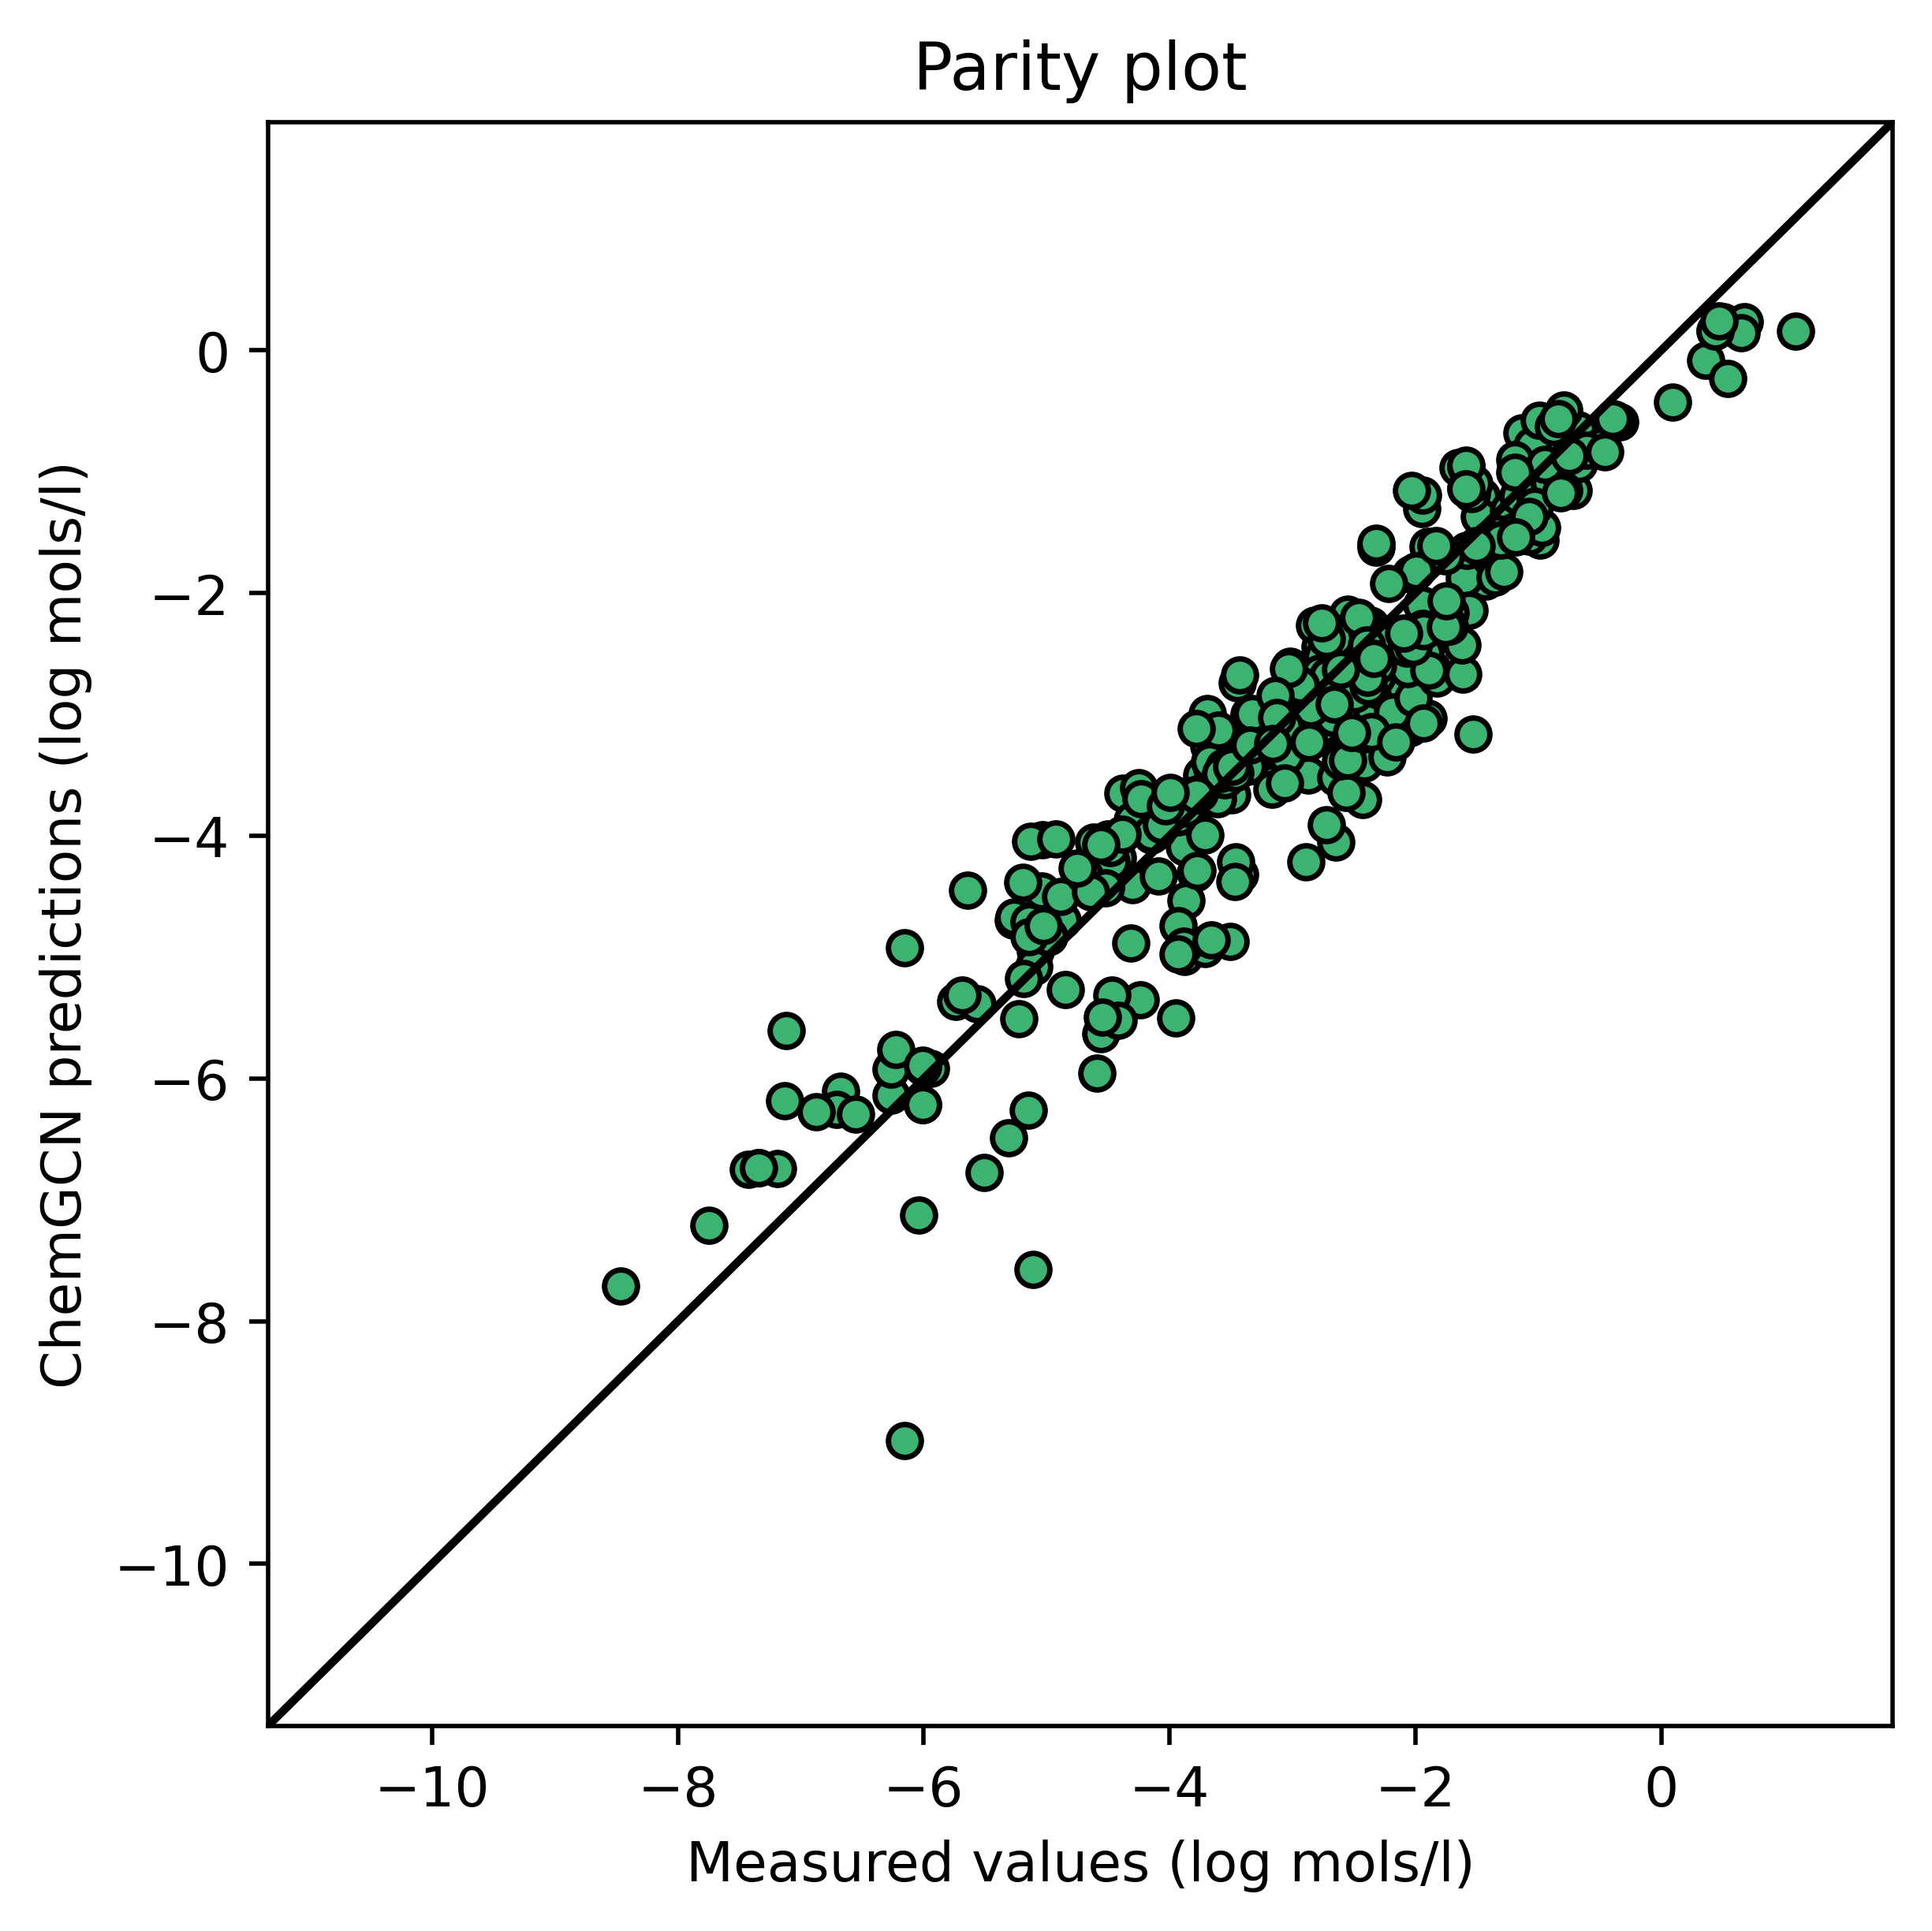

In [ ]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size,
                          sampler=train_sampler,
                          collate_fn=collate_graph_dataset)
test_dataloader = DataLoader(dataset, batch_size=batch_size,
                         sampler=test_sampler,
                         collate_fn=collate_graph_dataset)

save_dir = "/content/"
parity_plot(save_dir, model, test_dataloader, standardizer, use_GPU, max_atoms, node_vec_len)

In [ ]:
type(epoch)

list

In [ ]:
type(loss)

list

In [ ]:
# Convert PyTorch tensors to NumPy arrays
losses = [loss_item.item() for loss_item in loss]

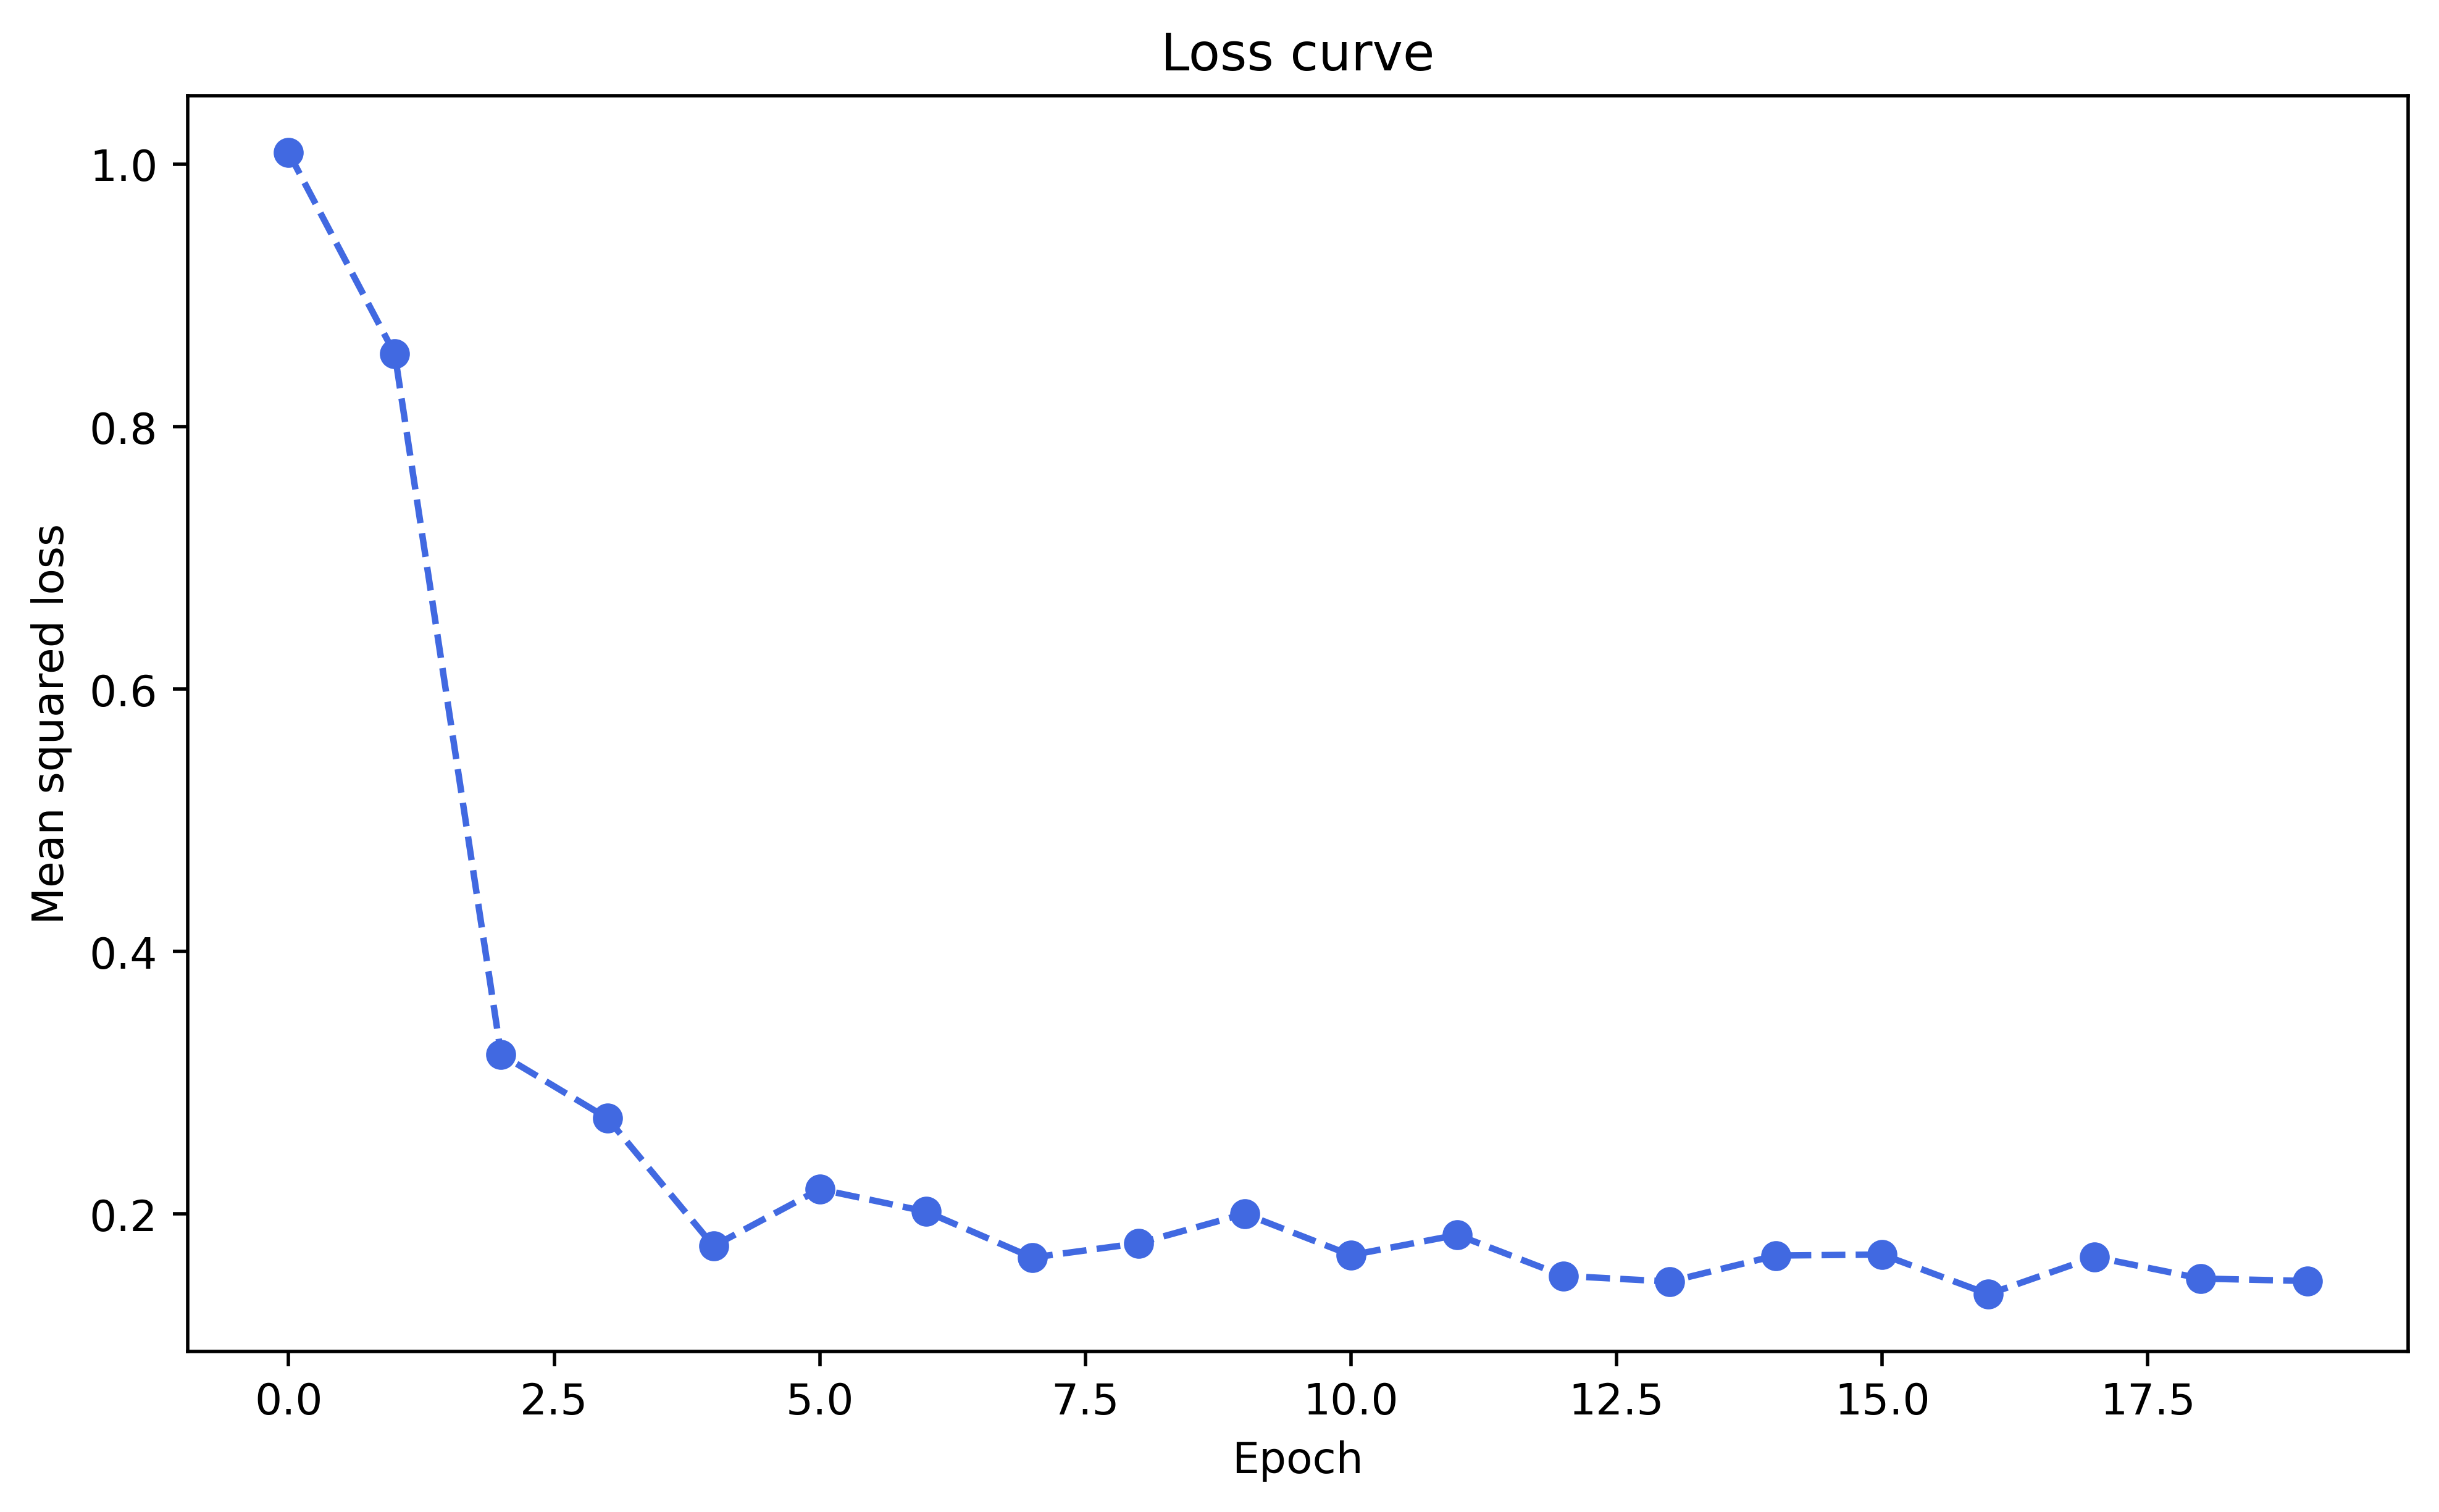

In [ ]:
loss_curve(save_dir, epoch, losses)

### Building A Graph Convolutional Network for Molecular Property Prediction

https://towardsdatascience.com/building-a-graph-convolutional-network-for-molecular-property-prediction-978b0ae10ec4